In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from sklearn.linear_model import Lasso
from scipy.stats import uniform
from sklearn.linear_model import Ridge

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    # this is a static function, similar to C++
    # does not binded with a class instance
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

C:\Users\acfin\AppData\Local\Temp\ipykernel_24956\2474408479.py:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


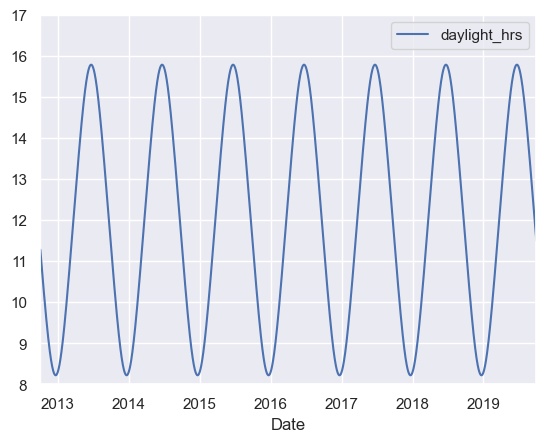

In [32]:
import pandas as pd
# these two files are large, and it may take a while to read...
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Linear Regression

In [33]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

# a little bit different than our previous example
# this plot is from pandas
daily[['Total', 'predicted']].plot(alpha=0.5)

# the estimated beta0 to betan
params = pd.Series(model.coef_, index=X.columns)
params

import matplotlib.pyplot as plt

daily[:5]
daily.corr(method='spearman')


ValueError: Invalid parameter 'alpha' for estimator LinearRegression(fit_intercept=False). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].

Lasso

In [45]:
model = Lasso(max_iter=10000)

parameters = param_dist = {
    'alpha' : uniform(0, 1.0)
}

randm_src = RandomizedSearchCV(
    model,      # The Lasso model
    param_distributions=param_dist,
)
randm_src.fit(X_train, y_train)

print("Best Alpha")
print(randm_src.best_params_)
print(randm_src.best_score_)

Best Alpha
{'alpha': 0.9869555418713482}
0.8586380183462635


Ridge

In [44]:
model = Ridge()  # Use Ridge regression

parameters = param_dist = {
    'alpha': uniform(0, 1.0)  # Change the range to [0, 1]
}

randm_src = RandomizedSearchCV(
    model,  # Use Ridge model
    param_distributions=param_dist
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
randm_src.fit(X_train, y_train)

print("Best Alpha")
print(randm_src.best_params_)
print(randm_src.best_score_)

Best Alpha
{'alpha': 0.9963644043978894}
0.8589405078975304
